### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
# Computational packages
import numpy as np
import torch
import tqdm

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')

# General packages
import datetime
import sys
import os

# custom packages
import ratsimulator
from ratsimulator.Environment import Rectangle
import spatial_maps as sm # CINPLA spatial maps

# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 
from PlaceCells import PlaceCells
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *
from plotting_functions import *

### Setup Experiment

In [3]:
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name = 'gg-3ME', base_path=base_path)
experiment.setup()

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


False

In [4]:
pc_ensembles = experiment.pc_ensembles

In [5]:
panesize = set_size(width=345, mode='square')
panesize

(4.77376504773765, 4.77376504773765)

In [6]:
def border_color(ax, color):
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(color)

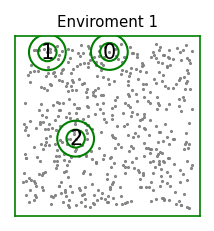

In [7]:
figsize = (panesize[0]/3, panesize[1]/3)
fig, ax = plt.subplots(figsize=figsize)

j = 1
colors = ['red','green','blue']
x,y = pc_ensembles[j].pcs.T
ax.scatter(x, y, alpha=1, color='grey')#, s=1)

for i in range(3):
    ax.text(x[i], y[i], f"{i}", color='black', ha='center', va='center', fontsize=10)
    a_circle = plt.Circle((x[i], y[i]), pc_ensembles[j].pc_width, fill=False, color=colors[j])
    ax.add_artist(a_circle)
    a_circle = plt.Circle((x[i], y[i]), 2*pc_ensembles[j].pc_width, fill=False, color=colors[j])
    ax.add_artist(a_circle)

ax.set_xticks([], [])
ax.set_yticks([], [])
border_color(ax, color=colors[j])
ax.set_title(f'Enviroment {j}')

fig.savefig(experiment.paths['experiment'] / f'plots/place-remapping-{j}')

## Create Place Cell Ratemap Plots

In [8]:
res = 128
pos = np.mgrid[0:res,0:res].T * experiment.environments[0].boxsize[0] / res

num_cells = 3
pc_responses = np.zeros((len(pc_ensembles), res, res, num_cells))
ratemaps = []
for env_i in range(len(pc_ensembles)):
    pc_responses[env_i] = pc_ensembles[env_i].softmax_response(torch.tensor(pos))[...,:num_cells].detach().numpy()
    ratemaps.append([])
    for cell_i in range(num_cells):
        ratemap = scipy.stats.binned_statistic_2d(pos[...,0].flatten(), pos[...,1].flatten(), pc_responses[env_i,...,cell_i].flatten(), bins=res).statistic
        ratemaps[env_i].append(ratemap)
    
ratemaps = np.array(ratemaps)
pos.shape, pc_responses.shape, ratemaps.shape

((128, 128, 2), (3, 128, 128, 3), (3, 3, 128, 128))

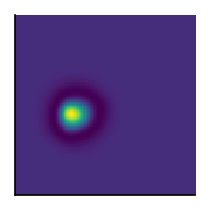

In [9]:
figsize = (panesize[0]/3, panesize[1]/3)
fig, ax = plt.subplots(figsize=figsize)
env_i, cell_i = 0, 0
plt.imshow(ratemaps[env_i, cell_i].T, origin='lower')
ax.set_xticks([], [])
ax.set_yticks([], [])

fig.savefig(experiment.paths['experiment'] / f'plots/place-remapping-ratemap-{env_i}-{cell_i}')

## Create Trajectory Example

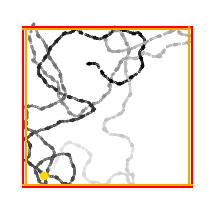

In [10]:
agent = experiment.agents[0]

agent.reset()
for _ in range(nsteps:=1000):
    agent.step()

# plot track
figsize=(panesize[0]/3,panesize[1]/3) # keep square
fig,ax=plt.subplots(figsize=figsize)
plt.axis('off')

# plot board and trajectory
experiment.environments[0].plot_board(ax)
agent.plot_trajectory(ax,ds=8)

a_circle = plt.Circle(agent.positions[0], 2.2*0.02, fill=True, color='gold')#, color=color)
ax.add_artist(a_circle)

fig.savefig(experiment.paths['experiment'] / 'plots/rat-trajectory-example')

In [11]:
ratemaps.shape

(3, 3, 128, 128)

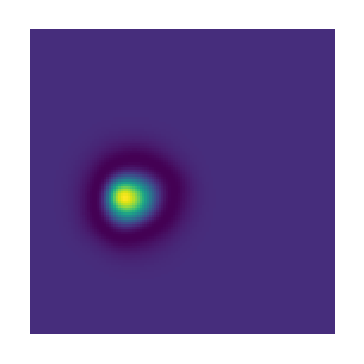

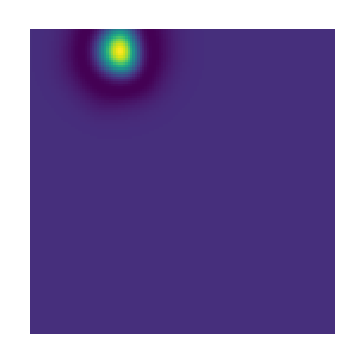

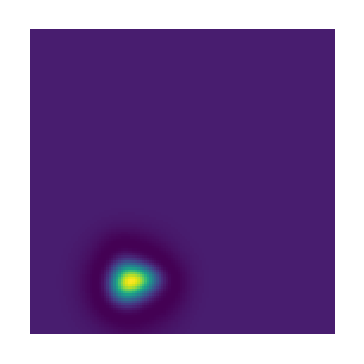

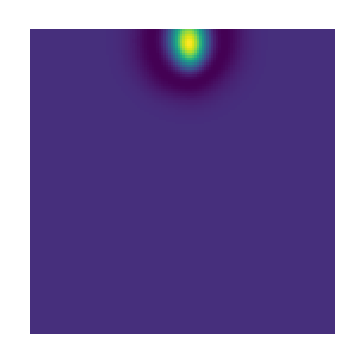

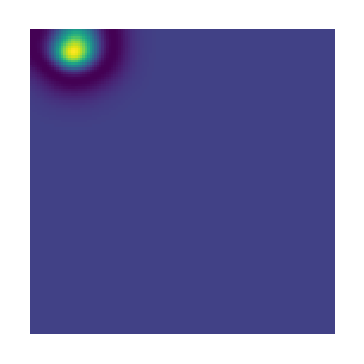

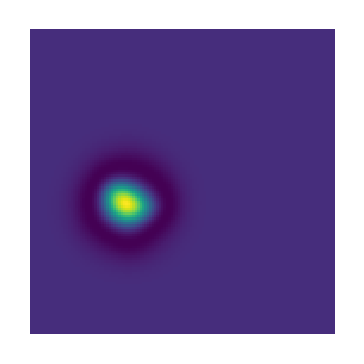

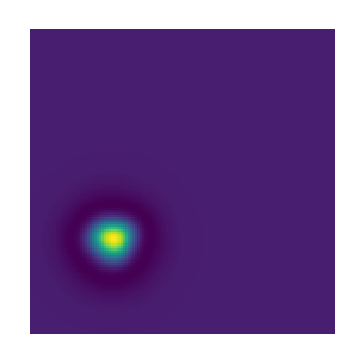

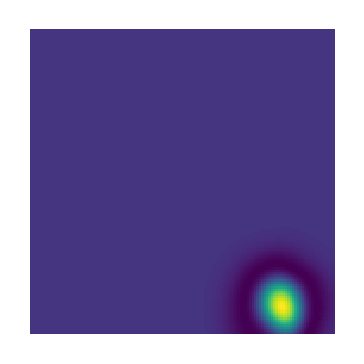

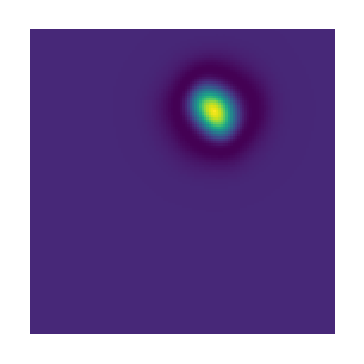

In [13]:
figsize = (12.5/12,12.5/12)
vmin = np.min(ratemaps)
vmax = np.max(ratemaps)
padding=-0.025
for env_i in range(len(pc_ensembles)):
    for cell_i in range(num_cells):
        fig, ax = plt.subplots(figsize=figsize,dpi=300)
        ax.imshow(ratemaps[env_i, cell_i].T, origin='lower')#, vmin=vmin, vmax=vmax)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        ax.axis('off')
        ax.set_position([-padding, -padding, 1+padding, 1+padding])
        fig.savefig(experiment.paths['experiment'] / f'plots/place-remapping-ratemap-{env_i}-{cell_i}.svg')